## Enhancing Anomaly Detection Methods for Energy Time Series Using Latent Space Data Representations
This notebook contains code to replicate the results of the non-sequential machine learning pipeline demonstrated at deRSE-2023 for enhancing anomaly detection. This code is based on the following paper:
>M. Turowski, B. Heidrich, K. Phipps, K. Schmieder, O. Neumann, R. Mikut, and V. Hagenmeyer, 2022, "Enhancing Anomaly Detection Methods for Energy Time Series Using Latent Space Data Representations," in The Thirteenth ACM International Conference on Future Energy Systems (e-Energy ’22). ACM, pp. 208–227. doi: [10.1145/3538637.3538851](https://doi.org/10.1145/3538637.3538851).


<br/>

### How Does Our Approach Work?
Before explaining the pipeline used to enhance anomaly detection methods, lets take a brief look at how the approach actually works. Basically, the main assumption of the approach is that a latent space data representation of time series can be advantageous for detecting anomalies. We assume, that time series samples containing anomalies can be better separated from non-anomalous time series samples in a latent space data representation. If this is true, then existing anomaly detection methods should perform better on the latent space data representation of the time series.

Therefore, our approach first involves creating a latent space data representation of the time series:
- We create this representation with a conditional Invertible Neural Network (cINN).
- The cINN is trained on anomaly free data to only learn "normal" behavior.

Given this trained cINN, we perform anomaly detection as follows:
- We use a time series segment possibly containing anomalies an input in the cINN to create a latent space representation of this time series.
- We apply existing anomaly detection methods directly to this latent space representation of the time series segment.
- The anomaly detection method returns a binary output indicating whether the time series segment considered contains anomalies or not.

In our paper we also considered a conditional Variational Autoencoder (cVAE) as an alternative generative model to create the latent space data representation. Furthermore, we also included an extension to perform unsupervised anomaly detection. In this example for the deRSE23 we are going to stick to a simple example though, and just consider the cINN in a supervised setting.

### Setting up the Pipeline
TODO - Describe the pipeline in more detail once the code is there

In [6]:
import functools
import warnings

import pandas as pd
from pywatts.modules import SKLearnWrapper, CalendarExtraction, CalendarFeature, Select, FunctionModule, \
    PowerAnomalyGeneration
from pywatts.summaries import F1Score
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts_pipeline.utils._xarray_time_series_utils import numpy_to_xarray
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from modules.inn_wrapper import INNWrapper
from utils.load_data import load_elec_data

warnings.filterwarnings('ignore')

def get_flat_output(data, filter = lambda data: data >= 1):
    flattened = filter(data).any(axis=1).astype(int)
    return numpy_to_xarray(flattened, data)


generator = INNWrapper("cINN", epochs=50, supervised=True)

scaler = SKLearnWrapper(StandardScaler())
# Create Pipeline
pipeline_anomaly_generation = Pipeline(f"../results/anomalyGeneration")

anomaly_type1 = PowerAnomalyGeneration(
    name='type1', anomaly='type1', count=5, label=1,
    length_params={
        'distribution': 'uniform',
        'min': 1,
        'max': 5
    },
    )(x=pipeline_anomaly_generation['input'])

# Type 2: Drop to potentially zero followed by a positive power spike
anomaly_type2 = PowerAnomalyGeneration(
    name='type2', anomaly='type2', count=5, label=2,
    length_params={'distribution': 'uniform', 'min': 1, 'max': 5, },
)(x=anomaly_type1['type1'], labels=anomaly_type1['labels'])

# Type 3: Sudden negative power spike
anomaly_type3 = PowerAnomalyGeneration(
        name='type3', anomaly='type3', count=5, label=3,
        anomaly_params={
            'is_extreme': False,
            'range_r': (1, 1.5),
        }
    )(x=anomaly_type2['type2'], labels=anomaly_type2['labels'])

# Type 4: Sudden positive power spike
anomaly_type4 = PowerAnomalyGeneration(
    name='type4', anomaly='type4', count=5, label=4, seed=4,
    anomaly_params={'range_r': (1, 1.5)}
)(x=anomaly_type3['type3'], labels=anomaly_type3['labels'])

pipeline = Pipeline(f"../results/anomalinn")
generated_anomalies = pipeline_anomaly_generation(input=pipeline["load_power_statistics"])
calendar = CalendarExtraction(country="BadenWurttemberg",
                              features=[CalendarFeature.hour,
                                        CalendarFeature.weekend,
                                        CalendarFeature.month])(x=pipeline["load_power_statistics"])

scaled_anomaly_free = scaler(x=pipeline['load_power_statistics'])
scaled_anomaly_free = Select(0, 24, 1)(x=scaled_anomaly_free)

calendar = Select(0, 24, 1)(x=calendar)

generator(cal_input=calendar, input_data=scaled_anomaly_free)

scaled = scaler(x=generated_anomalies["type4__type4"])
scaled_sampled = Select(0, 24, 1)(x=scaled)
unscaled_sampled = Select(0, 24, 1)(x=generated_anomalies["type4__type4"])

latent = generator(cal_input=calendar, input_data=scaled_sampled,
                   computation_mode=ComputationMode.Transform)

gt = Select(0, 24, 1)(x=generated_anomalies["type4__labels"])
gt = FunctionModule(functools.partial(get_flat_output))(data=gt)

svc_latent = SKLearnWrapper(SVC(), name="SVC latent")(x=latent, target=gt)
svc_scaled = SKLearnWrapper(SVC(), name="SVC scaled")(x=scaled_sampled, target=gt)
svc_unscaled = SKLearnWrapper(SVC(), name="SVC unscaled")(x=unscaled_sampled, target=gt)

F1Score(average="macro")(y=gt, svc_latent=svc_latent, svc_unscaled=svc_unscaled, svc_scaled=svc_scaled)


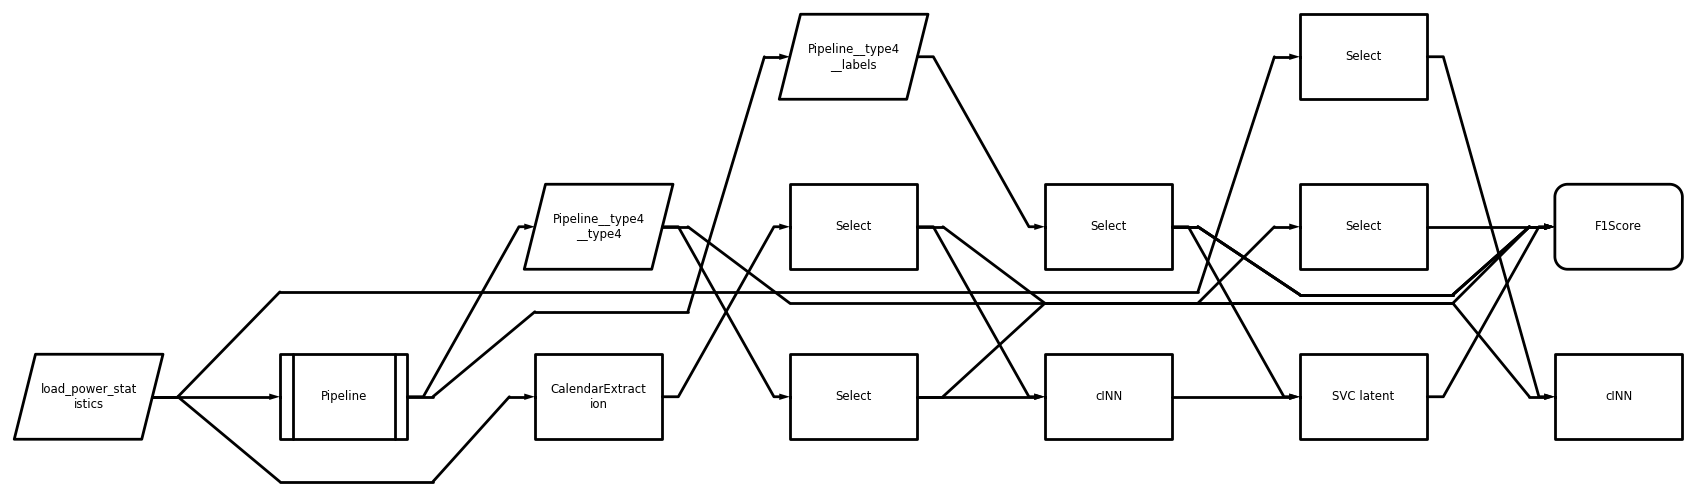

In [7]:
pipeline.draw(skip=["SampleModule", "StandardScaler", "SVC scaled", "SVC unscaled",
                    "FunctionModule"]).draw()

### Reading in the Data
TODO - Describe the data in more detail once the code is there

In [8]:
data = load_elec_data()

train_data = data[:6000]
test_data = data[6000:]

### Training the Pipeline
TODO - Describe the training process in more detail once the code is there

In [9]:
pipeline.train(train_data)

0, 0, 4782, 0.5081416964530945, 0.4980027675628662
1, 0, 4782, 0.4474371075630188, 0.4450066387653351
2, 0, 4782, 0.36938318610191345, 0.3590114116668701
3, 0, 4782, 0.2596128582954407, 0.2509317398071289
4, 0, 4782, 0.155746191740036, 0.13909746706485748
5, 0, 4782, 0.04846997559070587, 0.04056360572576523
6, 0, 4782, -0.049961477518081665, -0.05087105929851532
7, 0, 4782, -0.151875302195549, -0.16741248965263367
8, 0, 4782, -0.3081323504447937, -0.3282216191291809
9, 0, 4782, -0.4968027174472809, -0.5124237537384033
10, 0, 4782, -0.6713771820068359, -0.6881215572357178
11, 0, 4782, -0.8348664045333862, -0.8500654697418213
12, 0, 4782, -0.9828217029571533, -0.9909124374389648
13, 0, 4782, -1.1061161756515503, -1.1036381721496582
14, 0, 4782, -1.171188473701477, -1.1903172731399536
15, 0, 4782, -1.2320470809936523, -1.256746530532837
16, 0, 4782, -1.3126767873764038, -1.3153561353683472
17, 0, 4782, -1.3518695831298828, -1.3665071725845337
18, 0, 4782, -1.4050151109695435, -1.407432556

({'cINN': <xarray.DataArray (time: 5977, dim_0: 24)>
  array([[-1.3996418 , -0.6276822 , -0.03382927, ...,  1.0302593 ,
          -0.34650654,  0.29399303],
         [-1.6989555 , -0.39193052, -1.6361542 , ...,  0.70615846,
          -0.8854896 ,  0.7093258 ],
         [-1.9515915 ,  1.0144266 , -0.9902768 , ...,  0.71633923,
           1.6510108 , -1.5892135 ],
         ...,
         [ 0.56281966,  1.0957301 ,  1.2391906 , ..., -1.2018065 ,
          -0.73692405,  0.65314126],
         [-0.9711981 , -1.2175823 ,  0.6526209 , ..., -0.09949784,
           2.0805528 , -0.13559282],
         [-0.9795777 ,  0.8766681 ,  0.7466638 , ..., -0.71972966,
          -1.1435535 , -2.3365579 ]], dtype=float32)
  Coordinates:
    * time     (time) datetime64[ns] 2018-01-01 2018-01-01T01:00:00 ... 2018-09-07
    * dim_0    (dim_0) int32 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23,
  'SVC latent': <xarray.DataArray (time: 5977, dim_0: 1)>
  array([[0],
         [0],
         [0],
         ..

### Testing the pipeline
TODO - Describe the testing process and results in more detail once the code is there

In [10]:
from pywatts_pipeline.core.summary.summary_formatter import SummaryJSON

_, summary = pipeline.test(test_data, summary_formatter=SummaryJSON())
pd.DataFrame(summary["Summary"]["F1Score"])

,additional_information,results
svc_latent,,0.779279
svc_scaled,,0.727172
svc_unscaled,,0.727172


We hope you found this example interesting. If you have any questions please don't hesitate to contact us at [pywatts-team@iai.kit.edu](mailto:pywatts-team@iai.kit.edu)